# Geostrophic calculation 
## from sea surface height and GO-SHIP line P18

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import gsw

In [2]:
# read in the Satellite SSH data
ds=nc.Dataset('zos_AVISO_L4_clim.nc')
print(ds.variables.keys())

dict_keys(['time', 'time_bnds', 'lon', 'lon_bnds', 'lat', 'lat_bnds', 'zos'])


In [3]:
# read in lon, lat, ssh
lon=ds['lon'][:]
lat=ds['lat'][:]
ssh=ds['zos'][:]
ssh0=np.squeeze(np.mean(ssh,0)) # annual mean SSH map

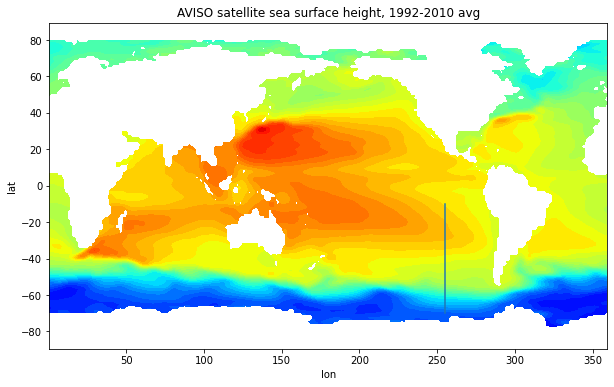

In [4]:
# plot a global map
plt.figure(figsize=(10,6))
ct=np.arange(-2,2.1,.1)
plt.contourf(lon,lat,ssh0,ct,cmap='jet') 
plt.plot([255, 255],[-70, -10],'-') # draw a line at 105W
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('AVISO satellite sea surface height, 1992-2010 avg')
plt.show()

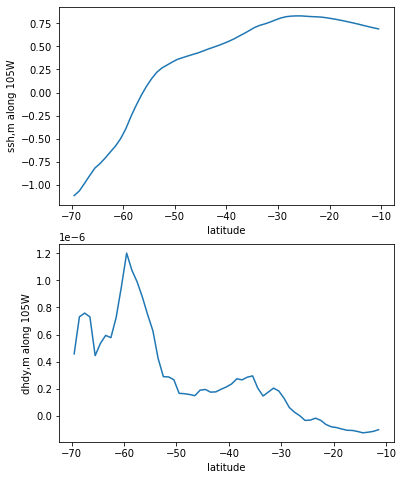

In [5]:
# SSH along 250W from 70S to 10S
indx=(lon==360-105.5)
indy=(lat>=-70)&(lat<=-10)
h=ssh0[indy,indx] 
lath=lat[indy]

# calculate dhdy
dy=6.37E+6*(np.pi/180) # distance for 1 deg in latitude
dhdy=(h[1:]-h[:-1])/dy # dhdy

plt.figure(figsize=(6,8))
plt.subplot(211)
plt.plot(lath,h)
plt.xlabel('latitude')
plt.ylabel('ssh,m along 105W')
plt.subplot(212)
plt.plot(lath[:-1],dhdy)
plt.xlabel('latitude')
plt.ylabel('dhdy,m along 105W')
plt.show()

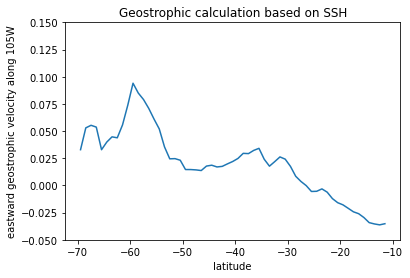

In [6]:
# Coriolis parameter for each latitude points
fcori=2*(2*np.pi)/(60.*60*24.)*np.sin(lath[:-1]*np.pi/180)

# geostrophic velocity
g=9.8
ug=-g*dhdy.T/fcori

plt.plot(lath[:-1],ug.T)
plt.xlabel('latitude')
plt.ylim([-.05,.15])
plt.ylabel('eastward geostrophic velocity along 105W')
plt.title('Geostrophic calculation based on SSH')
plt.show()

###  We see the geostrophic velocity at the surface at about 10cm/s or so at 60S based on the satellite data (AVISO annual mean from 1992 to 2010)
## Now we re-calculate Ug at 60S using T/S measurements from the P18 cruise. 
### Station 184 is at 58S and Station 189 is at 60.5S. We first calculate the specific volume, and vertically integrate hydrostatic balance to obtain dynamic height. 


In [7]:
# recap from HW2
# Step 1 download data from P18 cruise data
df=pd.read_csv('33RO20161119_hy1.csv',skiprows=149)
data=df.to_numpy()
stn=data[1:,2]
lat=data[1:,9].astype(float)
lon=data[1:,10].astype(float)
p=data[1:,12].astype(float)
t=data[1:,13].astype(float)
sp=data[1:,14].astype(float)

In [8]:
# calculate specific volume
SA=gsw.SA_from_SP(sp,p,-lon,lat)
CT=gsw.CT_from_t(SA,t,p)
sv=gsw.specvol(SA,CT,p)
svref=gsw.specvol(35,0,p)
sva=sv-svref

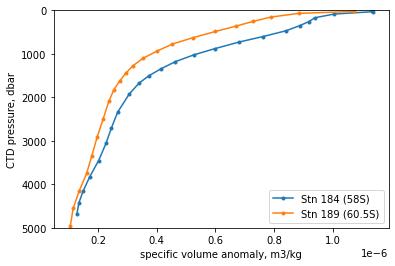

In [9]:
# quick look at the two stations
ind184 = (stn==184)
ind189 = (stn==189)
plt.plot(sva[ind184],p[ind184],'.-')
plt.plot(sva[ind189],p[ind189],'.-')
plt.legend(['Stn 184 (58S)','Stn 189 (60.5S)'])
plt.ylim([5000,0])
plt.xlabel('specific volume anomaly, m3/kg')
plt.ylabel('CTD pressure, dbar')
plt.show()

In [10]:
# integrate from the 3000 dbar level and integrate toward the surface
pref = 4000

# first station 189 (60.5S)
ind = ind189 & (p<pref)
p0=p[ind]
sva0=sva[ind]
# calculate dp
dp=(p0[1:]-p0[:-1])*1.E+4 # from dbar to Pa
sva1=.5*(sva0[:-1]+sva0[1:]) # mid-point spec vol
p1=.5*(p0[:-1]+p0[1:]) # mid-point pressure value
ht=np.cumsum(-sva1*dp/g)
ht189=ht
p189=p1

# next station 184 (58S)
ind = ind184 & (p<pref)
p0=p[ind]
sva0=sva[ind]
# calculate dp
dp=np.diff(p0)*1.E+4 # from dbar to Pa
sva1=.5*(sva0[0:-1]+sva0[1:])
p1=.5*(p0[0:-1]+p0[1:])
ht=np.cumsum(-sva1*dp/g)
ht184=ht
p184=p1

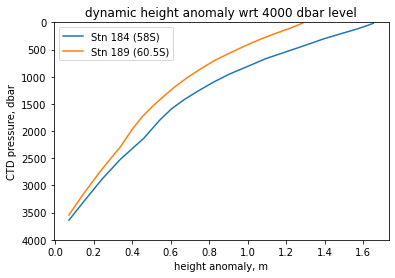

In [11]:
# plot dyn height profile
plt.plot(ht184,p184)
plt.plot(ht189,p189)
plt.legend(['Stn 184 (58S)','Stn 189 (60.5S)'])
plt.ylim([4000,0])
plt.title('dynamic height anomaly wrt '+str(pref)+' dbar level')
plt.xlabel('height anomaly, m')
plt.ylabel('CTD pressure, dbar')
plt.show()

In [14]:
# calculate the geostrophic velocity between the two stations (let's say 59S)
fcori = 2*(2*np.pi/86400.)*np.sin(-59.0*np.pi/180)
dy=2.5*6.37E+6*(np.pi/180)
# dhdy at the surface
dhdy=(ht184[-1]-ht189[-1])/dy
# geostrophic velocity
ug=-g/fcori*dhdy
print('estimated surface geostrophic velocity at (110W,59S) is '+str(ug.round(3)),'m/s')

estimated surface geostrophic velocity at (110W,59S) is 0.104 m/s


In [15]:
# The satellite SSH and dynamic height (thermal wind) are very close to one another. 